#### thankGOD! this code should be run in the tf_env of conda and can not be run in base enviroment of conda thankGOD!

In this code we want to use NN to predict the Rg of IDPs. The training data set is 28000 simulation proteins of Keresten group with 12 sequence features of them. Then we use SHAP to find important sequence features on Rg prediction. We compare NN regression with polynomial regression. We also predict delta Rg which is the difference of simulation and experimental Rg.

In [22]:
%cd /media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Keresten/data/Rg/

/media/saeed/Expansion/ASU/md-intro-tutorial/ml_project/Keresten/data/Rg


Define main data set

In [23]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt



In [24]:
# Replace 'your_file.csv' with the path to your CSV file
df = pd.read_csv('IDRome_DB.csv', usecols=['Rg/nm','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])

# Separate the target (Rg) and features
X_large = df.drop(columns=['Rg/nm'])  # Features (all columns except 'Rg')
y_large = df['Rg/nm']  # Target (only the 'Rg' column)
#print (y_large.shape)

Define 64 exp deta set for test

In [25]:
df = pd.read_csv('rg_test_data_features3_keresten.csv', usecols=['exp_rg','N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr'])

# Separate the target (Rg) and features
X_small = df.drop(columns=['exp_rg'])  # Features (all columns except 'Rg')
y_small= df['exp_rg']  # Target (only the 'Rg' column)

### Step 1: Import Libraries

### Step 2: Preprocess the Data

Neural networks work better when the data is standardized (scaled to have a mean of 0 and standard deviation of 1).

In [26]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
from tensorflow.keras.backend import clear_session
clear_session()


# thankGOD! train the model on Rg

In [27]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Split your large dataset into train and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_large, y_large, test_size=0.2, random_state=42)

# Step 1: Split into training/validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X_large, y_large, test_size=500/28058, random_state=42)

# Step 2: Further split training/validation into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Print sizes of each set
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Apply the same scaler to the smaller 64-sample dataset
X_test = scaler.transform(X_test)
# Ensure consistent input shapes
#X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

Training set: (22046, 12), Validation set: (5512, 12), Test set: (500, 12)


### Step 3: Define the Neural Network Model

We’ll create a small neural network with a couple of hidden layers and use dropout for regularization.

In [28]:
#from tensorflow.keras.layers import Dense, LeakyReLU
# Initialize the model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='elu'))
#model.add(Dense(64, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(64, input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(Dropout(0.01))  # Dropout layer to prevent overfitting
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(32, activation='elu'))
#model.add(Dense(32, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(12, activation='elu'))
#model.add(Dense(12, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# third hidden layer with 32 neurons
model.add(Dense(12, activation='elu'))
#model.add(Dense(12, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))


# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



### Step 4: Train the Model

We’ll use the training data and monitor performance on the validation set.

In [29]:
# Train the model
#history = model.fit(X_train, y_train, epochs=30, batch_size=272, validation_data=(X_val, y_val), verbose=1)

In [30]:
# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)
# Fit the model with early stopping for normalization
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=72,
    callbacks=[early_stopping],  # Add the callback here
    verbose=1
)


Epoch 1/100
307/307 [==============================] - 0s 650us/step - loss: 1.2007 - val_loss: 0.0478
Epoch 2/100
307/307 [==============================] - 0s 467us/step - loss: 0.0916 - val_loss: 0.0311
Epoch 3/100
307/307 [==============================] - 0s 641us/step - loss: 0.0716 - val_loss: 0.0263
Epoch 4/100
307/307 [==============================] - 0s 872us/step - loss: 0.0696 - val_loss: 0.0208
Epoch 5/100
307/307 [==============================] - 0s 496us/step - loss: 0.0613 - val_loss: 0.0182
Epoch 6/100
307/307 [==============================] - 0s 565us/step - loss: 0.0542 - val_loss: 0.0200
Epoch 7/100
307/307 [==============================] - 0s 809us/step - loss: 0.0485 - val_loss: 0.0164
Epoch 8/100
307/307 [==============================] - 0s 853us/step - loss: 0.0478 - val_loss: 0.0147
Epoch 9/100
307/307 [==============================] - 0s 435us/step - loss: 0.0477 - val_loss: 0.0191
Epoch 10/100
307/307 [==============================] - 0s 592us/step - l

### Step 5: Evaluate the Model on the New 64-Sample Dataset

After training, you can evaluate the model on your smaller test set.

In [31]:
# Predict on the 64-sample dataset
y_pred_nn = model.predict(X_test)
#y_pred_nn = model.predict(X_test_tensor)
#print (len(y_pred_nn))
# Calculate MSE and R-squared for the 64-sample dataset
#mse_nn = mean_squared_error(y_small, y_pred_nn)
#r2_nn = r2_score(y_small, y_pred_nn)

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print("Neural Network MSE on 64-sample dataset:", mse_nn)
print("Neural Network R-squared on 64-sample dataset:", r2_nn)


16/16 [==============================] - 0s 351us/step
Neural Network MSE on 64-sample dataset: 0.007783499928622714
Neural Network R-squared on 64-sample dataset: 0.9967513714438899


### Step 6: Plotting the Learning Curve (Optional)
To check for overfitting or underfitting, you can plot the learning curve:

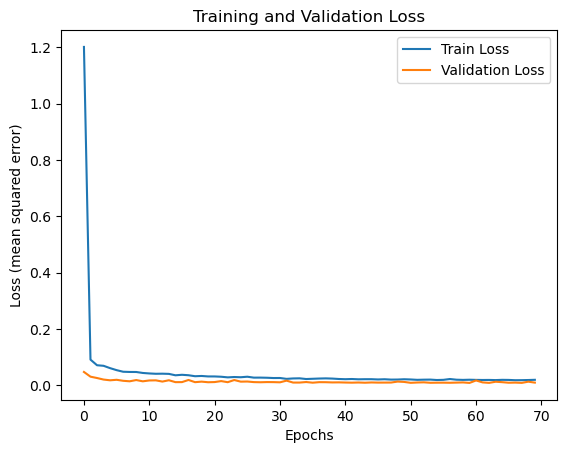

In [11]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (mean squared error)')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


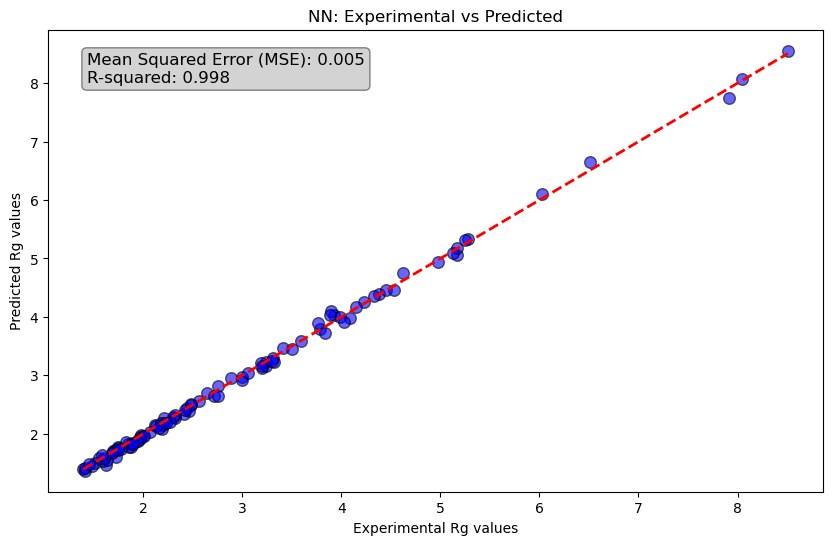

In [18]:
plt.figure(figsize=(10, 6))
#plt.scatter(y_small, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
#plt.plot([y_small.min(), y_small.max()], [y_small.min(), y_small.max()], 'r--', lw=2)
plt.scatter(y_test, y_pred_nn, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Experimental Rg values')
plt.ylabel('Predicted Rg values')
plt.title('NN: Experimental vs Predicted')

# Display MSE and R-squared inside the plot
text_str = f'Mean Squared Error (MSE): {mse_nn:.3f}\nR-squared: {r2_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

#### to plot the loss vs the training set size we need to run in different way

In [ ]:
# Assume X_large and y_large are the 28,000 samples
# Preprocess data
scaler = StandardScaler()
X_large_scaled = scaler.fit_transform(X_large)

# Define sizes for subsets (e.g., 1%, 5%, 10%, ..., 100% of the dataset)
training_sizes = np.linspace(0.01, 1.0, 10)  # Fractions of training samples
training_losses = []
validation_losses = []

# Validation set (20% of the full dataset)
split_idx = int(0.8 * len(X_large_scaled))
X_train_full, X_val = X_large_scaled[:split_idx], X_large_scaled[split_idx:]
y_train_full, y_val = y_large[:split_idx], y_large[split_idx:]

for size in training_sizes:
    # Determine subset size
    subset_size = int(size * X_train_full.shape[0])
    X_train_subset = X_train_full[:subset_size]
    y_train_subset = y_train_full[:subset_size]

    # Define a small neural network model
    model = Sequential([
        Dense(64, input_shape=(X_train_full.shape[1],), activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Train the model on the subset
    history = model.fit(X_train_subset, y_train_subset,
                        validation_data=(X_val, y_val),
                        epochs=50, batch_size=32, verbose=0)

    # Record the final training and validation losses
    training_losses.append(history.history['loss'][-1])
    validation_losses.append(history.history['val_loss'][-1])

# Plot Loss vs. Training Set Size
plt.figure(figsize=(8, 6))
plt.plot(training_sizes * X_train_full.shape[0], training_losses, label='Training Loss', marker='o')
plt.plot(training_sizes * X_train_full.shape[0], validation_losses, label='Validation Loss', marker='o')
plt.xlabel('Number of Training Samples')
plt.ylabel('Loss (Mean Squared Error)')
plt.title('Loss vs. Training Set Size')
plt.legend()
plt.grid()
plt.show()


PermutationExplainer explainer: 501it [00:18, 13.05it/s]                                              


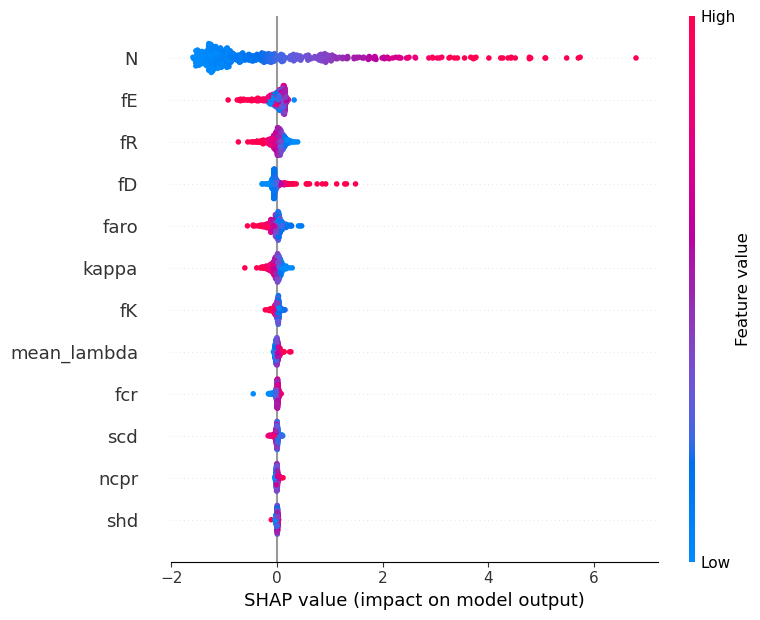

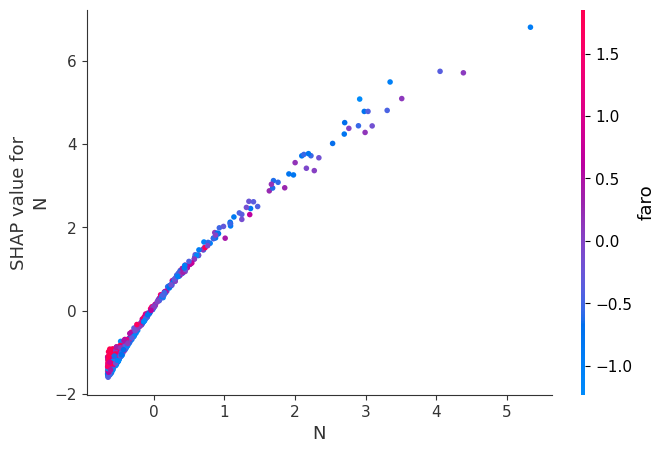

In [11]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD',	'faro','kappa','fcr']  
X_test_df = pd.DataFrame(X_test, columns=feature_names)# Convert to DataFrame for better handling

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_test_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)

# thankGOD! delta Rg

### thankGOD! delta Rg for 28000 sim and predicted

In [32]:
Rg_sim = np.array (y_test)
Rg_pred = np.array (y_pred_nn)

In [33]:
#delta_Cs = Cs_exp - Cs_pred
delta_Rg=[]

for i in range (len(y_pred_nn)):
    #print (delta_Rg[i])
    delta_Rg.append( Rg_pred[i]- Rg_sim[i] )
#print (delta_Rg.min())


In [34]:
delta_Rg = scaler.fit_transform(delta_Rg)
print (max(delta_Rg))

[6.99169666]


In [35]:
#Clear the Session: If you’re running the script multiple times in the same session (e.g., in Jupyter), 
#clear TensorFlow's computational graph between runs to avoid accumulation:
from tensorflow.keras.backend import clear_session
clear_session()

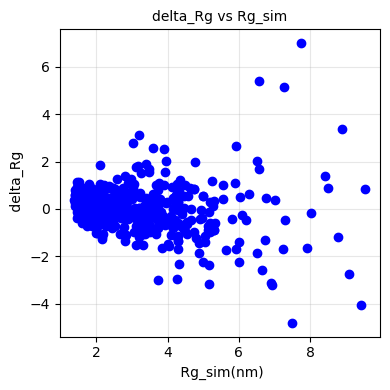

In [36]:
# Plotting
fig, ax = plt.subplots(figsize=(4,4))


ax.plot(Rg_sim, delta_Rg,'o',color='b')#,fillstyle='none')


ax.set(xlabel=f' Rg_sim(nm)', ylabel=f' delta_Rg')
ax.set_title('delta_Rg vs Rg_sim',fontsize=10)
ax.grid(alpha=0.3)

fig.tight_layout()

# ThankGOD! train the model on delta Rg

In [18]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


# Step 1: Split 500 sample that we have delta Rg into training/validation and test sets
X_train_val_dRg, X_test_dRg, y_train_val_dRg, y_test_dRg = train_test_split(X_test, delta_Rg, test_size=20/500, random_state=42)

# Split your large dataset into train and validation sets
# we select X_train and val from the remaining of 500 samples thankGOD!
X_train_dRg, X_val_dRg, y_train_dRg, y_val_dRg = train_test_split(X_train_val_dRg, y_train_val_dRg, test_size=0.2, random_state=42)


# Print sizes of each set
print(f"Training set: {X_train_dRg.shape}, Validation set: {X_val_dRg.shape}, Test set: {X_test_dRg.shape}")

# Standardize the data
scaler = StandardScaler()
X_train_dRg = scaler.fit_transform(X_train_dRg)
X_val_dRg = scaler.transform(X_val_dRg)

#y_train = scaler.fit_transform(y_train)
#y_val = scaler.fit_transform(y_val)

# Apply the same scaler to the smaller 64-sample dataset
X_test_dRg = scaler.transform(X_test_dRg)
delta_Rg = scaler.fit_transform(delta_Rg)
y_test_dRg=scaler.fit_transform(y_test_dRg)
print (y_test_dRg)


Training set: (384, 12), Validation set: (96, 12), Test set: (20, 12)
[[ 0.80954404]
 [ 0.53124309]
 [-0.01122498]
 [ 0.25424148]
 [-0.43189094]
 [ 0.87444002]
 [-2.49780475]
 [ 0.32717578]
 [ 0.91718975]
 [-1.03444416]
 [ 0.48119203]
 [-0.20989658]
 [ 2.34304079]
 [ 0.6431587 ]
 [-0.61712064]
 [-0.37849969]
 [-1.72007622]
 [-0.30280218]
 [-0.1215753 ]
 [ 0.14410977]]


### polynomial regression

Root Mean Squared Error: 0.08822414595008961
R-squared: -0.053949355965538626


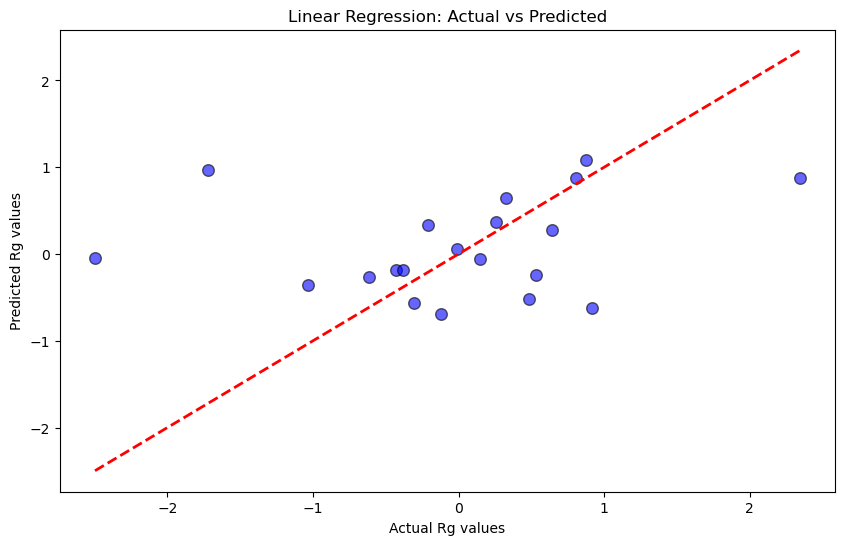

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Using a polynomial degree of 2 for demonstration
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train_dRg, y_train_dRg)
y_pred_poly = poly_model.predict(X_test_dRg)


# Evaluate the model
mse = mean_squared_error(y_test_dRg, y_pred_poly)
rmse_nn = np.sqrt(mse_nn)
r2 = r2_score(y_test_dRg, y_pred_poly)
print("Root Mean Squared Error:", rmse_nn)
print("R-squared:", r2)

# Visualization of results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test_dRg, y_pred_poly, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_test_dRg.min(), y_test_dRg.max()], [y_test_dRg.min(), y_test_dRg.max()], 'r--', lw=2)
plt.xlabel('Actual Rg values')
plt.ylabel('Predicted Rg values')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

### Step 3: Define the Neural Network Model¶

In [21]:
#from tensorflow.keras.layers import Dense, LeakyReLU
# Initialize the model
model = Sequential()

# Input layer and first hidden layer with 64 neurons and ReLU activation
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
#model.add(Dense(64, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(64, input_shape=(X_train.shape[1],), activation='sigmoid'))
model.add(Dropout(0.01))  # Dropout layer to prevent overfitting
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(32, activation='relu'))
#model.add(Dense(32, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# Second hidden layer with 32 neurons
model.add(Dense(32, activation='relu'))
#model.add(Dense(32, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))


# Second hidden layer with 32 neurons
model.add(Dense(12, activation='relu'))
#model.add(Dense(12, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))
#model.add(kernel_regularizer=l2(0.01))

# third hidden layer with 32 neurons
model.add(Dense(12, activation='relu'))
#model.add(Dense(12, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))

# third hidden layer with 32 neurons
model.add(Dense(12, activation='relu'))
#model.add(Dense(12, input_shape=(X_train.shape[1],)))
#model.add(LeakyReLU(alpha=0.01))
#model.add(Dense(32, activation='sigmoid'))
model.add(Dropout(0.01))


# Output layer for regression
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)
# Fit the model with early stopping for normalization
history = model.fit(
    X_train_dRg, y_train_dRg,
    validation_data=(X_val_dRg, y_val_dRg),
    epochs=100,
    batch_size=72,
    callbacks=[early_stopping],  # Add the callback here
    verbose=1
)

Epoch 1/100
6/6 [==============================] - 0s 13ms/step - loss: 0.9631 - val_loss: 1.0241
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9554 - val_loss: 1.0195
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9495 - val_loss: 1.0163
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9435 - val_loss: 1.0117
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9348 - val_loss: 1.0078
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9289 - val_loss: 1.0054
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9174 - val_loss: 1.0039
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9098 - val_loss: 1.0022
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.9031 - val_loss: 0.9980
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.8972 - val_loss: 0.9982
Epoch 11/100
6/6 [==========

### R2

In [23]:
import joblib

# Predict on the 64-sample dataset
y_pred_dRg = model.predict(X_test_dRg)
#y_pred_nn = model.predict(X_test_tensor)
print (max(y_pred_dRg))


# to save the trained model. if we want to not to go back again and train the model every time.
joblib.dump(model, 'dRg_model.joblib')

1/1 [==============================] - 0s 31ms/step
[1.5825232]


['dRg_model.joblib']

In [24]:

# Calculate MSE and R-squared for the 64-sample dataset
mse_nn = mean_squared_error(y_test_dRg, y_pred_dRg)
rmse_nn = np.sqrt(mse_nn)
# Manual RMSE calculation
#rmse_nn = np.sqrt(np.mean((np.array(delta_Rg) - np.array(y_pred_nn))**2))

r2_nn = r2_score(y_test_dRg, y_pred_dRg)

print("Neural Network RMSE on 64-sample dataset:", rmse_nn)
print("Neural Network R-squared on 64-sample dataset:", r2_nn)

Neural Network RMSE on 64-sample dataset: 1.0803445842393187
Neural Network R-squared on 64-sample dataset: -0.1671444206952264


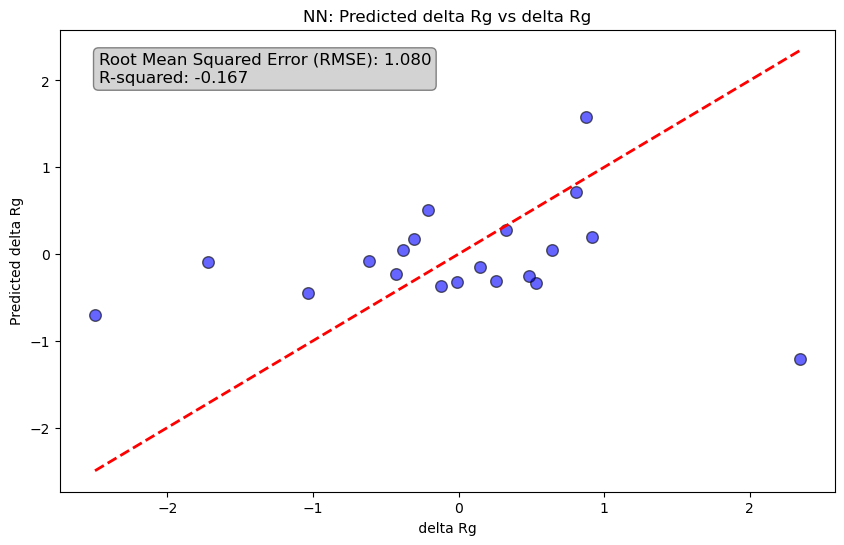

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_dRg, y_pred_dRg, color='blue', edgecolor='k', alpha=0.6, s=70)
plt.plot([y_test_dRg.min(), y_test_dRg.max()], [y_test_dRg.min(), y_test_dRg.max()], 'r--', lw=2)
plt.xlabel(' delta Rg ')
plt.ylabel('Predicted delta Rg')
plt.title('NN: Predicted delta Rg vs delta Rg')

# Display MSE and R-squared inside the plot
text_str = f'Root Mean Squared Error (RMSE): {rmse_nn:.3f}\nR-squared: {r2_nn:.3f}'
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgray'))

plt.show()

### Train with cross validation

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_test_dRg.shape[1]),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(1, activation='linear')
    ])
    #model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the early stopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
r2_scores = []

all_y_true = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in kf.split(X_test_dRg):
    # Split the data
    X_train, X_val = X_test_dRg[train_index], X_test_dRg[val_index]
    y_train, y_val = y_test_dRg[train_index], y_test_dRg[val_index]

    # Create a new instance of the model
    model = create_model()
 
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=72, callbacks=[early_stopping], verbose=1)

    # Predict on the test set
    y_pred_dRg = model.predict(X_test_dRg)

        # Append true and predicted values
    all_y_true.extend(y_test_dRg)
    all_y_pred.extend(y_pred_dRg.flatten())  # Flatten predictions
    
    mse = mean_squared_error(y_test_dRg, y_pred_dRg)
    mse_scores.append(mse)

      # Calculate R-squared
    r2 = r2_score(y_test_dRg, y_pred_dRg)
    r2_scores.append(r2)

# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Output results
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Mean MSE: {mean_mse:.4f}, Std Dev: {std_mse:.4f}")
print(f"Cross-validated R-squared scores: {r2_scores}")
print(f"Mean R-squared: {mean_r2:.4f}, Std Dev: {std_r2:.4f}")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], color='red', linestyle='--')  # Diagonal line
plt.title(f"Scatter Plot of True vs. Predicted Values\nMean $R^2$: {mean_r2:.4f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

### thankGOD! one leave out cross validation

Epoch 1/100
1/1 [==============================] - 0s 361ms/step - loss: 1.0170
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0332
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0039
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9972
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9886
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9993
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9810
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9850
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9587
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9543
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.9435
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.9595
Epoch 13/100
1/1 [==============================] - 0s 1ms/

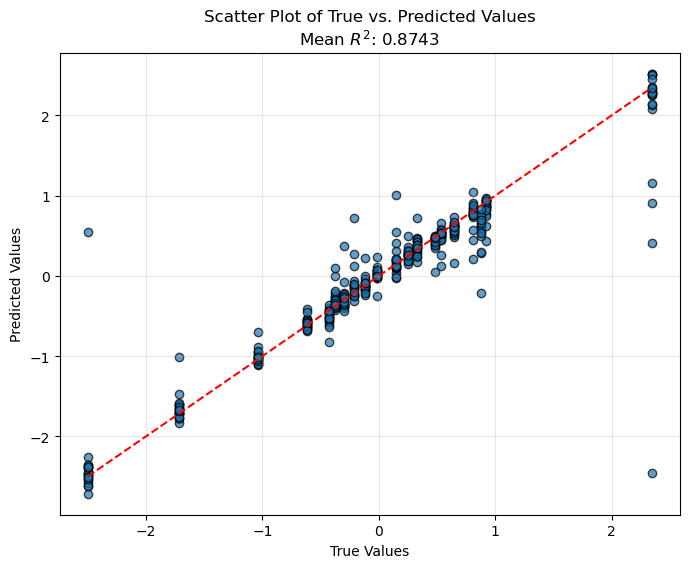

In [37]:
#Modified Code for LOOCV

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import LeaveOneOut

# Define the Keras model
def create_model():
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_test_dRg.shape[1]),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(32, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(12, activation='relu'),
        Dropout(0.01),
        Dense(1, activation='linear')
    ])
    #model.compile(optimizer='adam', loss='mse')
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Define the early stopping callback
    early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10,            # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Cross-validation setup
#kf = KFold(n_splits=10, shuffle=True, random_state=42)
loo = LeaveOneOut()
mse_scores = []
r2_scores = []

all_y_true = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in loo.split(X_test_dRg):
    # Split the data
    X_train, X_val = X_test_dRg[train_index], X_test_dRg[val_index]
    y_train, y_val = y_test_dRg[train_index], y_test_dRg[val_index]

    # Create a new instance of the model
    model = create_model()
 
    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=72, callbacks=[early_stopping], verbose=1)

    # Predict on the test set
    y_pred_dRg = model.predict(X_test_dRg)

        # Append true and predicted values
    all_y_true.extend(y_test_dRg)
    all_y_pred.extend(y_pred_dRg.flatten())  # Flatten predictions
    
    mse = mean_squared_error(y_test_dRg, y_pred_dRg)
    mse_scores.append(mse)

      # Calculate R-squared
    r2 = r2_score(y_test_dRg, y_pred_dRg)
    r2_scores.append(r2)

# Calculate the mean and standard deviation of the MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Output results
print(f"Cross-validated MSE scores: {mse_scores}")
print(f"Mean MSE: {mean_mse:.4f}, Std Dev: {std_mse:.4f}")
print(f"Cross-validated R-squared scores: {r2_scores}")
print(f"Mean R-squared: {mean_r2:.4f}, Std Dev: {std_r2:.4f}")


# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(all_y_true, all_y_pred, alpha=0.7, edgecolor='k')
plt.plot([min(all_y_true), max(all_y_true)], [min(all_y_true), max(all_y_true)], color='red', linestyle='--')  # Diagonal line
plt.title(f"Scatter Plot of True vs. Predicted Values\nMean $R^2$: {mean_r2:.4f}")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
ThankGOD! now we test this model on 

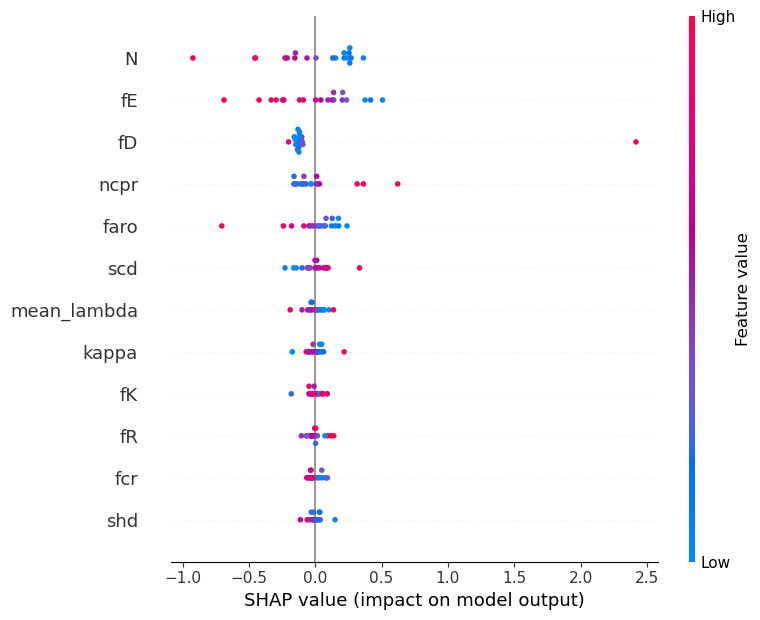

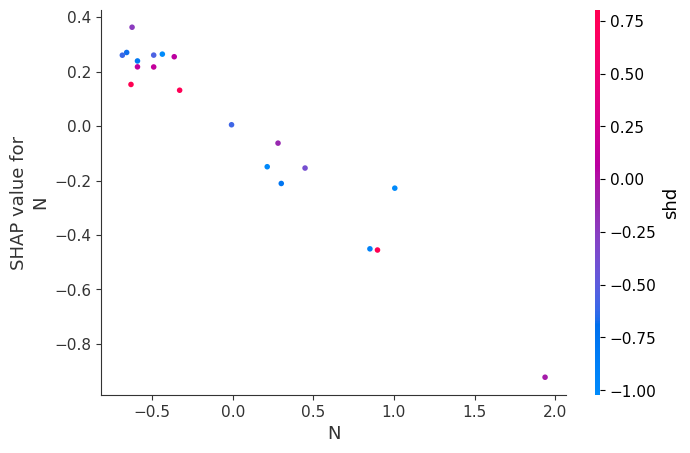

In [39]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer
explainer = shap.Explainer(model, X_test_dRg)
shap_values = explainer(X_test_dRg)

# Extract feature names 
feature_names = ['N','shd','scd','mean_lambda','ncpr','fK', 'fR', 'fE', 'fD','faro','kappa','fcr']  
X_test_df = pd.DataFrame(X_test_dRg, columns=feature_names)# Convert to DataFrame for better handling

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test_dRg, feature_names=feature_names)

# Create dependence plot for a single feature (e.g., 'f1')
shap.dependence_plot(
    0,  # feature to plot (replace with the desired feature name) 0 is for N and 1 is for shd and ... thankGOD!
    shap_values=shap_values.values,  # SHAP values for the test dataset
    features=X_test_df,  # Test dataset as a DataFrame
    feature_names=feature_names,  # Feature names for better readability
    
)